1. Read all the TSV files into an array, write a function to extract the title and authors data
2. Go through each TSV and use title and authors to search the OCLC for OWI number
3. Go through each OWI and get:
    3.1 Earliest year published
    3.2 Holdings
    3.3 For OWI with the most holdings: VIAF -> Genders
    3.5 For each OWI where "book" in .get("format")
    Make Genders -> DDC dict, add to it manually
4. Make a dict of TITLE/AUTHOR STRING -> OWI, YEAR_PUBLISHED, GENDER(S), TOP_DDC, FAST_LIST?

In [1]:
import csv, os
from datetime import datetime
f_filen = "tabula-1963-03-17.tsv"
nf_filen = "tabula-1963-03-17-nf.tsv"
data_i = 2 #How far into the tsv file the data shows up...
fields = ['rank','title+author','rank_last_week','weeks_on_list']
stop_words_authors = ["Others"]

# Read the Data In

In [2]:
def empty(row):
    if row[0]=="":
        return True
    return False 

def extract_date(datestr):
    try:
        date = datetime.strptime(datestr[0],'%B %d, %Y')
    except ValueError:
        date = datetime.strptime(datestr[0],'%B %d,%Y')
    return date

def extract_date_filen(datestr):
    f_from_path = datestr.split("/")[2]
    wo_extension = f_from_path.split(".")[0]
    date = datetime.strptime(wo_extension,'%Y-%m-%d')
    return date

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def header(row):
    if is_number(row[0]):
        return False
    else:
        return True
    
def read_tsv(name):
    i = 0
    arr = []
    date = ""
    with open(name) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        for row in reader:
            if (not empty(row)):
                if (header(row)) & (i>data_i):
                    return arr
                if i==0:
                    date_field = [row[1]]
                    if row[1] == "":
                        date_field = [row[2]]
                    try:
                        date = extract_date(date_field)
                    except:
                        date = extract_date_filen(name)
                if (i > data_i):
                    arr.append([date]+row)
                i = i+1
        return arr
    
def read_folder(folderpath):
    arr = []
    for f in os.listdir(folderpath):
        commasv = read_tsv(folderpath+f)
        arr = arr+commasv
    return arr

eighty_path = "tsvs/1980s/"
eighties = read_folder(eighty_path)
seventies_path = "tsvs/1970s/"
seventies = read_folder(seventies_path)
sixties_path = "tsvs/1960s/"
sixties = read_folder(sixties_path)
fifties_path = "tsvs/1950s/"
fifties = read_folder(fifties_path)

nineties = read_folder("tsvs/1990s/")
thousands = read_folder("tsvs/2000s/")

for x in nineties[0:10]:
    print x
    
    
to_process = fifties + sixties + seventies + eighties + nineties + thousands
print len(to_process)

[datetime.datetime(1996, 5, 19, 0, 0), '2', 'THE TENTH INSIGHT, by James Redfield. (Warner, $19.95.) A journey through', '3', '2']
[datetime.datetime(1996, 5, 19, 0, 0), '3', 'MOONLIGHT BECOMES YOU, by Mary Higgins Clark. (Simon & Schuster, $24.)', '1', '5']
[datetime.datetime(1996, 5, 19, 0, 0), '4', 'MALICE, by Danielle Steel. (Delacorte, $24.95.) A woman struggles to overcome', '2', '4']
[datetime.datetime(1996, 5, 19, 0, 0), '5', 'THE CELESTINE PROPHECY, by James Redfield. (Warner, $17.95.) An ancient', '5', '116']
[datetime.datetime(1996, 5, 19, 0, 0), '6', 'PRIMARY COLORS, by Anonymous. (Random House, $24.) The progress of a', '4', '15']
[datetime.datetime(1996, 5, 19, 0, 0), '7', 'TIMEPIECE, by Richard Paul Evans. (Simon & Schuster, $18.) By sharing grief', '7', '3']
[datetime.datetime(1996, 5, 19, 0, 0), '8', 'NEANDERTHAL, by John Darnton. (Random House, $24.) The discovery in', '12', '3']
[datetime.datetime(1996, 5, 19, 0, 0), '9', 'THE HORSE WHISPERER, by Nicholas Evans. (Del

# Get Title and Author

In [3]:
skip_these = set()

In [4]:
auth_i = 4

# strip trailing char if '.' or ' '
def strip_trailing_punct(a):
    last_char = a[len(a)-1]
    if (last_char != '.') & (last_char != ' '):
        return a
    b = a[:len(a)-1] 
    return strip_trailing_punct(b)


def parse_author_phrase(a_ph):
    authors = []
    end = len(a_ph)
    parens = a_ph.find("(")
    if parens != -1:
        end = parens-1
    auth_ph = a_ph[auth_i:end]
    if " and " in auth_ph:
        author_arr = auth_ph.split(" and ")
        for author in author_arr:
            author = strip_trailing_punct(author)
            if author not in stop_words_authors:
                authors.append(author)
    else:
        author = auth_ph
        author = strip_trailing_punct(author)
        authors.append(author)
    return authors

def title_author_pair(data_str):
    split_str = data_str.split(',')
    title = ""
    auth_ph = ""
    i=0
    t=True
    for phrase in split_str:    
        if i == 0:
            title = phrase
        else:
            if phrase.isupper() & t:
                title = title + ", "+phrase
            else:
                t = False
                auth_ph = auth_ph+phrase
        i = i+1
    try:
        authors = parse_author_phrase(auth_ph)
        if authors == []:
            authors = [data_str]
    except:
        skip_these.add(data_str)
        authors = [data_str]
    return (title,authors)

ta = set()
for x in thousands:
    title = str(title_author_pair(x[2]))
    ta.add(title)
print len(ta)
print len(thousands)


i =0 
for x in ta:
    print x
    i = i+1
    if i>10:
        break


2836
11499
('IDENTICAL', ['Scott Turow'])
('THE TEHRAN INITIATIVE', ['Joel C. Rosenberg'])
('DEAD AIM', ['Iris Johansen'])
('PLAIN JANE', ['Fern Michaels'])
('LOVE,  DISHONOR,  MARRY,  DIE,  CHERISH,  PERISH', ['David Rakoff'])
('SIZZLING SIXTEEN', ['Janet Evanovich'])
('CHAINFIRE', ['Terry Goodkind'])
('SHADOW OF POWER', ['Steve Martini'])
('WINTER STREET', ['Elin Hilderbrand'])
('PRIVATE', ['James Patterson', 'Maxine Paetro'])
('SKIN TRADE', ['Laurell K. Hamilton'])


In [5]:
print title_author_pair("THE LAST HURRAH, by Margaret Attenbourough. (gestated in utero.)")

('THE LAST HURRAH', ['Margaret Attenbourough'])


In [6]:
print skip_these

set(['HIDDEN PASSIONS: Secrets From the Diaries of Tabitha Lenox.', 'HIDDEN PASSIONS: Secrets From the Diaries of Tabitha Lenox. (Harper', 'ALL THE LIGHT WE CANNOT SEE. by Anthony Doerr. (Scribner.) The lives of a'])


# To OCLC


In [7]:
import xml.etree.ElementTree
import json,pickle
import urllib2
import re

oclc_base = "http://classify.oclc.org/classify2/Classify?"
alph = re.compile('[^a-zA-Z]')
suffixes = ['CPA', 'CSC', 'CSJ', 'DC', 'DD', 'DDS', 'DMD', 'DO', 'DVM', 'EDD', 'ESQ', 'II', 'III', 
            'IV', 'INC', 'JD', 'JR', 'LLD', 'LTD', 'MD', 'OD', 'OSB', 'PC', 'PE', 'PHD', 'RET', 
            'RGS', 'RN', 'RNC', 'SHCJ', 'SJ', 'SNJM', 'SR', 'SSMO', 'USA', 'USAF', 'USAFR', 'USAR', 
            'USCG', 'USMC', 'USMCR', 'USN', 'USNR']

In [8]:
def write_obj(obj,filename):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(filename):
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
        return b
    
ta_to_data_dict = load_obj("rock_and_roll.pickle") 

In [11]:
def suffix(phrase):
    norm_phrase = phrase.replace(',',"").upper()
    if norm_phrase in suffixes:
        return True
    else:
        return False
    
def strip_punct(text):
    return alph.sub('', text)

def norm_text(text):
    return strip_punct(text).lower()

def url_to_data(url,f):
    req = urllib2.Request(url)
    req.add_header('User-agent', 'Mozilla 5.10')
    res = urllib2.urlopen(req)
    if(f=="xml"):
        data = xml.etree.ElementTree.parse(res).getroot()
    if(f=="json"):
        data = json.load(res)
    return data

def convert_to_search(name):
    return_string = ""
    last_ch = " "
    for ch in name:
        if (ch == " "):
            if (last_ch != "."):
                return_string = return_string + "+"
        else:
            if ch == ".":
                return_string = return_string +".+"
            else:
                return_string = return_string+ch
        last_ch = ch
    return return_string

def last_name_recursive(name,last_index):
    if last_index == 0:
        return ""
    last_phrase = name[last_index]
    if not suffix(last_phrase):
        return last_phrase
    else:
        return last_name_recursive(name, last_index-1)

def last_name(name):
    names = name.split(" ")
    last_index = len(names)-1
    last = last_name_recursive(names,last_index)
    return last

def first_name(name):
    names = name.split(" ")
    return names[0]

In [9]:
from lxml import html
from bs4 import BeautifulSoup
import requests

viaf_base = "http://www.viaf.org/viaf/"
    
def get_gender_scrape(i):
    url = viaf_base+str(i)+"/"
    data = requests.get(url).text
    soup = BeautifulSoup(data,"lxml")
    personal = soup.find('div',{'id':'personalinfo'})
    if personal is None:
        return ""
    h4s = personal.find('h4')
    if (h4s is None) or (len(h4s)<5):
        return ""
    mt = []
    i=0
    for h in h4s:
        mt.append(h)
        i = i+1
    return str(mt[4])

In [27]:
def is_book(w,t,a):
    if "book" in norm_text(w.get("format")):
        if norm_text(t) in norm_text(w.get("title")):
            for auth in a:
                if norm_text(last_name(auth)) in norm_text(w.get("author")):
                    if norm_text(first_name(auth))in norm_text(w.get("author")):
                        return True
    return False

def find_all_works(xml,title,authors):
    works = xml.find('{http://classify.oclc.org}works')
    if works is None:
        works = []
        works.append(xml.find('{http://classify.oclc.org}work'))
#        print works
        if (works is None) or works == []:
            return []
    books = []
    for w in works:
        holdings = w.get("holdings")
        if (int(holdings) > 10) & (is_book(w,title,authors)):
            owi = w.get("owi")
            try:
                lyr = w.get("lyr")
            except:
                lyr = ""
            books.append({"owi":owi,"holdings":holdings,"lyr":lyr})
    return books

def new_work(w, entries):
    if int(w['holdings']) < 50:
        return False
    for e in entries:
        if w['owi'] == e["owi"]:
             return False
    return True

def get_oclc_entries(title,authors):
    url = oclc_base +"title="+convert_to_search(title)
    #i = 0
    entries = []
    for a in authors:
        auth_url = url +"&author=" + last_name(a)
        xml = url_to_data(auth_url,"xml")
#        print xml
        try:
            works = find_all_works(xml,title,authors)
        except:
            return []
        if works is None:
            return []
        if entries == []:
            entries = works
        else:
            for w in works:
                if new_work(w,entries):
                    entries.append(w)
        #i = i+1
    return entries
    
print get_oclc_entries('BELOVED', ['Toni Morrison']) 
print get_oclc_entries('SEVEN DAYS IN MAY', ['Fletcher Knebel']) 

def max_holding(oarr):
    target = oarr[0]
    for o in oarr[1:]:
        if int(o['holdings'])>int(target['holdings']):
            target = o
    return target

def get_authors(xml):
    authors = xml.find('{http://classify.oclc.org}authors')
    target = []
    for a in authors:
        text = a.text
        v = a.get('viaf')
        target.append({'name':text, 'viaf':v})
    return target

def get_fast(xml):
    recs = xml.find('{http://classify.oclc.org}recommendations')
    target = []
    if recs is not None:
        fast = recs.find('{http://classify.oclc.org}fast')
        if fast is not None:
            headings = fast.find('{http://classify.oclc.org}headings')
            for h in headings:
                if int(h.get('heldby'))>10:
                    target.append(h.text)
    return target

def lookup_oclc(owi):
    url = oclc_base+"owi="+owi
    xml = url_to_data(url,"xml")
    try:
        v = get_authors(xml)
    except:
        print url
        print xml
        response_code = xml.find('{http://classify.oclc.org}response').get("code")
        if response_code == '102':
            print '102!'
    fast = get_fast(xml)
    target = {'authors':v,'fast':fast}
    return target

test_author_dict = [{'viaf': '22619695', 'name': 'Bailey, Charles Waldo, 1929-2012 [Author]'}, {'viaf': '19720195', 'name': 'Knebel, Fletcher'}]

def get_genders(authors, viaf_dict):
    target = []
    for a in authors:
        v = get_viaf(a,viaf_dict)
        gender = get_gender_scrape(v)
        target.append({"name":a,"viaf":v,"gender":gender})
    return target
    
def get_viaf(author, viaf_dict_arr):
    l = norm_text(last_name(author))
    f = norm_text(first_name(author))
    target = ""
    for v in viaf_dict_arr:
        if l in norm_text(v['name']):
            target = v['viaf']
            if f in norm_text(v['name']):
                return v['viaf']
    return target

#print(get_genders(["Fletcher Knebel","Charles W. Bailey II"],test_author_dict))


[{'holdings': '13357', 'owi': '989794', 'lyr': '1987'}, {'holdings': '1899', 'owi': '149526417', 'lyr': '1987'}, {'holdings': '61', 'owi': '1151679152', 'lyr': '1970'}, {'holdings': '27', 'owi': '4020568630', 'lyr': '2003'}]
[{'holdings': '2275', 'owi': '1380647', 'lyr': '1962'}, {'holdings': '82', 'owi': '1806398693', 'lyr': '1962'}]


In [28]:
skipped_ta = []
print len(ta_to_data_dict)

5544


In [29]:
def process_input_data(ta):       
    # if str(ta) not in ta_to_oclc_dict: CHECK FOR THIS OUTSIDE THE FN
    title = ta[0]
    author = ta[1]
    oclc = get_oclc_entries(title,author)
    if (oclc is None) or (len(oclc)<1):
        skipped_ta.append(ta)
        owi = []
        holdings = []
        year_pub = []
        fast_subjects = set()
        genders = []
    else:
        if len(oclc) == 1:
            primary = oclc[0]
            primary_data = lookup_oclc(primary['owi'])
            fast_subjects = set(primary_data['fast'])
        else:
            primary = max_holding(oclc)
            primary_data = lookup_oclc(primary['owi'])
            fast_subjects = set(primary_data['fast'])
            for o in oclc:
                if o['owi'] != primary['owi']:
                    other_data = lookup_oclc(o['owi'])
                    fast_subjects.update(other_data['fast'])
        owi = primary["owi"]
        year_pub = primary["lyr"]
        genders = get_genders(author, primary_data['authors'])
    return {"owi": owi, "year_pub": year_pub, "fast_subjects":fast_subjects, "genders":genders}

def needs_clean_up(book):
    # IF ONE OWI HAS FEWER THAN 10 ENTRIES, RETURN TRUE
    return True

def clean_up_pickle(the_pickle):
    for book in the_pickle:
        if needs_clean_up(book):
            return []


## need to add the original data (date, year, rankings) if this is the ultimate output
def process_raw_list(input_ls):
    #print "INPUT! "+ str(input_ls)
    target = []
    i = 0
    for row in input_ls:
        #print row
        if (i%1000 == 0):
            print i
            write_obj(ta_to_data_dict,"rock_and_roll.pickle")
        date = row[0]
        year = date.year
        if row[2] in skip_these:
            target_row = {"date":date,"title":row[2],"authors":row[2],"year":year,"owi":"","year_pub":"","fast_subjects":[],"genders":[]}
        else:
            ta = title_author_pair(row[2])
            target_row = {"date":date,"title":ta[0],"authors":ta[1],"year":year}
            string_ta = str(ta)
            if string_ta in ta_to_data_dict:
                target_row.update(ta_to_data_dict[string_ta])
            else:
                try:
                    processed = process_input_data(ta)
                    target_row.update(processed)
                    ta_to_data_dict[string_ta] = processed
                except:
                    target_row = {"date":date,"title":row[2],"authors":row[2],"year":year,"owi":"","year_pub":"","fast_subjects":[],"genders":[]}
                    if target_row not in skipped_ta:
                        skipped_ta.append(ta)
        target.append(target_row)
        i = i+1
    return target

processed = process_raw_list(to_process)#thousands)#+thousands[:2000])#thousands)#to_process)
print processed[0]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
http://classify.oclc.org/classify2/Classify?owi=156180631
<Element '{http://classify.oclc.org}classify' at 0x7fa75535ced0>
102!
http://classify.oclc.org/classify2/Classify?owi=190785116
<Element '{http://classify.oclc.org}classify' at 0x7fa75535cf10>
102!
39000
40000
http://classify.oclc.org/classify2/Classify?owi=1840315434
<Element '{http://classify.oclc.org}classify' at 0x7fa755a3fa50>
102!
41000
http://classify.oclc.org/classify2/Classify?owi=2409782529
<Element '{http://classify.oclc.org}classify' at 0x7fa755064ed0>
42000
43000
44000
http://classify.oclc.org/classify2/Classify?owi=303903928
<Element '{http://classify.oclc.org}classify' at 0x7fa754d7a2d0>
102!
http://classify.oclc.org/classify2/Classify?owi=2211640955
<Element '{http://classify.oclc.org}classify' a

In [30]:
print len(skipped_ta)

14


In [183]:
import matplotlib
%matplotlib inline

genre_terms = ["fiction","stories","tales","literature","opera"]
genre_dict = {"romance":{"keys":["romance","erotic"],"stops":["language"]}, #took out 'domestic'
              "suspense":{"keys":["suspense"]},
              "horror":{"keys":["horror","paranormal"]},
              "mystery":{"keys":["mystery","detective","crime"]},
              "spy_and_politics":{"keys":["spy ","politic"]},
              "fsf":{"keys":["fantasy","science fiction", "space","cyberpunk","steampunk"]},
              "adventure":{"keys":["adventure","western","sea "]},
              "ya":{"keys":["young adult"]},
              "war":{"keys":["war "]},
              "religious":{"keys":["religious","christian"],"stop":["aspects"]},
              "historical":{"keys":["historical"]} ## <-- I think this one might not be a well-supported
                                                   ## category in the DB
            }

def genre_candidate(fast_term):
    for term in genre_terms:
        if term in norm_text(fast_term):
            return True
    return False

def is_genre(fast_term,genre_str):
    terms = genre_dict[genre_str]['keys']
    if 'stops' in genre_dict[genre_str]:
        stops=genre_dict[genre_str]['stops']
    else:
        stops = []
    target = False
    for term in terms:
        if term in fast_term.lower():
            target = True
    for stop in stops:
        if stop in fast_term.lower():
            target = False
    return target

#def classify_genre(processed_row):
#    subjects = processed_row['fast_subjects']
def classify_genre(subjects):
    #print subjects
    target = {}
    for genre in genre_dict:
        target[genre]=0
    for subject in subjects:
        if genre_candidate(subject):
            for genre in genre_dict:
                if is_genre(subject,genre):
                    target[genre] = 1
    return target

def percent_genres(cl_ls):
    counts_dict = {}
    for genre in genre_dict:
        counts_dict[genre] = 0
    for x in cl_ls:
        for genre in genre_dict:
            counts_dict[genre] = counts_dict[genre]+x[genre]
    for genre in genre_dict:
        counts_dict[genre] = float(counts_dict[genre])/float(len(cl_ls))
    return counts_dict  

def tally_genres(cl_ls):
    counts_dict = {}
    for genre in genre_dict:
        counts_dict[genre] = 0
    for x in cl_ls:
        for genre in genre_dict:
            counts_dict[genre] = counts_dict[genre]+x[genre]
    return counts_dict  
    
def tally_genres_binned(cl_ls,group_val):
    df = pandas.DataFrame(cl_ls)
    grouped = df.groupby(group_val)
    target = []
    for group in grouped:
        classified = []
        index = group[0]
        ls_o_fast_lists = grouped.get_group(index)
        for fast_list in ls_o_fast_lists["fast_subjects"]:
            classified.append(classify_genre(fast_list))
        i = 0
        
        ## This is ugly, but I'm trying to figure out how to print the title of 
        ## books within a genre, the way I've done it. For spot-checking.
        
##        for c in classified:
##            if c["adventure"]==1:
##                print ls_o_fast_lists["title"][i]
            
        tallied = tally_genres(classified)
        tallied[group_val] = index
        target.append(tallied)
    return target

def percent_genres_binned(cl_ls,group_val):
    df = pandas.DataFrame(cl_ls)
    
    ## change the binning from average to sum
    df = df.drop_duplicates(["title","year"])
    
    grouped = df.groupby(group_val)
    target = []
    for group in grouped:
        classified = []
        index = group[0]
        ls_o_fast_lists = grouped.get_group(index)
        for fast_list in ls_o_fast_lists["fast_subjects"]:
            classified.append(classify_genre(fast_list))
        tallied = percent_genres(classified)
        tallied[group_val] = index
        target.append(tallied)
    return target

In [32]:
import pandas
print pandas.__version__

terms = []
for x in processed:
    for y in x['fast_subjects']:
        if genre_candidate(y):
            terms.append(y)
    
term_series = pandas.Series(terms)
counts = term_series.value_counts()
print len(processed)
print(counts)

0.19.2
44313
English fiction                               4716
Detective and mystery stories                 3437
American fiction                              3304
Romance fiction                               2652
Adventure stories                             2343
Historical fiction                            2056
Fiction                                       1953
Domestic fiction                              1886
Spy stories                                   1535
Suspense fiction                              1448
Psychological fiction                         1102
Science fiction                               1015
Horror tales                                   947
Legal stories                                  868
Fantasy fiction                                865
War stories                                    799
Spanish fiction                                789
Political fiction                              730
Short stories                                  692
American literatur

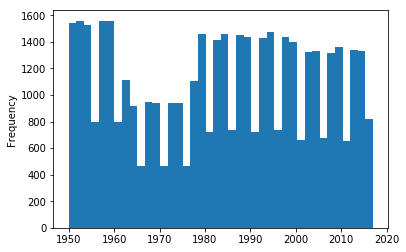

In [33]:
s = pandas.Series(pandas.DataFrame(processed)["year"])
s.plot(kind="hist",bins=40)

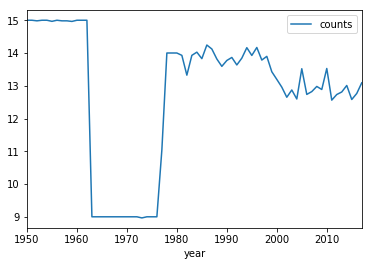

In [69]:
s = pandas.DataFrame(pandas.DataFrame(processed)[["year","date"]])
s['counts'] = s.groupby(['date']).transform('count')
s['counts'] = s['counts'].astype(int)
s_grouped = s.groupby("year")

fig_3 = s_grouped.mean().plot().get_figure()
fig_3.savefig("bestsellers_list_length.png")


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


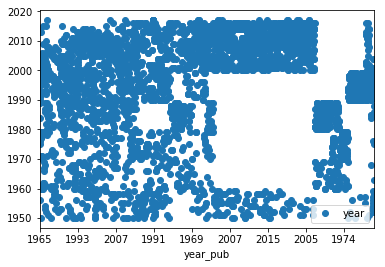

In [181]:
df = pandas.DataFrame(processed)
ndf = df[df.year_pub.notnull()]
ndf = ndf[ndf.year_pub != ""]
ndf = ndf[ndf.year_pub.str.len() != 0]
ndf["diff"] = ndf["year"] - ndf["year_pub"].astype(int)
ndf = ndf[ndf["diff"] < 50]
ndf = ndf.sort("diff",ascending = False)
ndf = ndf.drop_duplicates(["title","year_pub","diff"])
ndf.plot("year_pub","year", style='o')

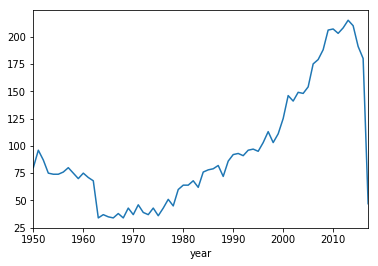

In [24]:
df = pandas.DataFrame(processed).groupby("year")
unique_counts = df.apply(unique_titles).apply(len)
fig = unique_counts.plot().get_figure()
fig.savefig("unique_titles_per_year.png")

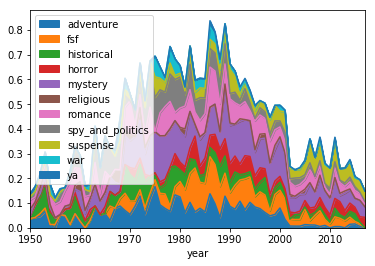

In [184]:
#tall_df = pandas.DataFrame(tally_genres_binned(processed,"year")).set_index("year")
#fig1 = tall_df.plot().get_figure()
#fig1.savefig("genre_tallies_year.png")

per_df = pandas.DataFrame(percent_genres_binned(processed,"year")).set_index("year")
fig = per_df.plot.area().get_figure()
fig.savefig("genre_percent_year.png")

#tall_week_df = pandas.DataFrame(tally_genres_binned(processed,"date")).set_index("date")
#fig4 = tall_week_df.plot.area().get_figure()
#fig.savefig("by_week.png")

False
True
1052
2809
0.272468272468
872
1760
0.331306990881


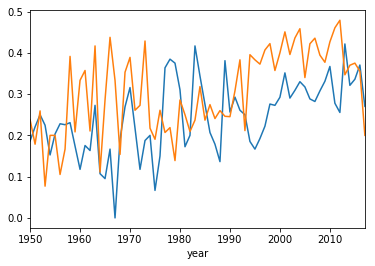

In [263]:
def is_any_genre(fast_ls):
    for x in fast_ls:
        for key in genre_dict:
            if is_genre(x,key):
                return True
    return False

df = pandas.DataFrame(processed)
df = df.drop_duplicates(["title","year"])
df["is_genre"] = df["fast_subjects"].apply(is_any_genre)
df["gender"] = df["genders"].apply(class_gender)

ndf = percent_women_binned(df,"year")
#df = df[df["year"].astype(int)>1990]

i = 0
grouped = df.groupby("is_genre")
for g in grouped:
    print g[0]
    p = percent_women_binned(g[1],"year")
    if i == 0:
        ax = pandas.DataFrame(p).set_index("year").plot(legend = False)
    else:
        pandas.DataFrame(p).set_index("year").plot(ax = ax,legend=False)
        fig = ax.get_figure()
        fig.savefig("genre_not_genre.png")
    i = i+1
    

grouped = df.groupby(["is_genre","gender"]).size()
grouped



i = 0
for x in grouped:
    if i%2 == 0:
        female = x
        print female
    else:
        male = x
        print male
        print float(female)/float(female+male)
    i = i+1



In [22]:
def csv_str(ls,delim):
    target = ""
    i = 0
    for x in ls:
        target = target + str(x)
        if (i == (len(ls)-1)):
            target = target + "\n"
        else:
            target = target + str(delim)
        i = i+1
    return target

def export_to_csv_for_viz(df,filename):
    ls = csv_format_arr(df)
    with open(filename, 'w') as f:
        for row in ls:
            f.write(csv_str(row,','))
    
def csv_format_arr(df):
    target = []
    for genre in per_df:
        print(genre)
        year_ls = per_df[genre]
        print type(year_ls)
        for year in year_ls.index.values:
            row = [year,genre]
            row.append(year_ls[year])
            target.append(row)
    return target

per_df
print export_to_csv_for_viz(per_df,"potatoe1s.csv") 

adventure
<class 'pandas.core.series.Series'>
fsf
<class 'pandas.core.series.Series'>
historical
<class 'pandas.core.series.Series'>
horror
<class 'pandas.core.series.Series'>
mystery
<class 'pandas.core.series.Series'>
religious
<class 'pandas.core.series.Series'>
romance
<class 'pandas.core.series.Series'>
spy_and_politics
<class 'pandas.core.series.Series'>
suspense
<class 'pandas.core.series.Series'>
war
<class 'pandas.core.series.Series'>
ya
<class 'pandas.core.series.Series'>
None


In [31]:
titles = ['A WIDOW FOR ONE YEAR','OF LOVE AND OTHER DEMONS','DANIEL MARTIN']

def books_in_genre(data,genre):
    target = set()
    for x in data:
        for f in x["fast_subjects"]:
            if genre_candidate(f) and is_genre(f,genre):
                if (x["title"] in titles) & (str((x["title"],x["authors"])) not in target):
                    print x["title"] + ' ' + f
                target.add(str((x["title"],x["authors"])))
    return target

fsf = books_in_genre(processed,"fsf")
mystery = books_in_genre(processed,"mystery")
war = books_in_genre(processed,"war") 
romance = books_in_genre(processed,"romance")
both = fsf.intersection(romance)

def print_head(sset,limit):
    i = 0
    for s in sset:
        if i>limit:
            return
        print s
        i = i+1

#print "WAR"
#print_head(war, 20)
#print "SPIES"
#print_head(spy, 20)
print "ROMANCE"
print_head(romance, 20)
print len(both)
for x in both:
    print x

DANIEL MARTIN Romance fiction
A WIDOW FOR ONE YEAR Romance fiction
OF LOVE AND OTHER DEMONS Romance fiction
ROMANCE
('SECRETS', ['Danielle Steel'])
('KALEIDOSCOPE', ['Danielle Steel'])
('THE LOVE MACHINE', ['Jacqueline Susann'])
('OF LOVE AND OTHER DEMONS', ['Gabriel Garcia Marquez'])
('THROUGH A GLASS DARKLY', ['Karleen Koen'])
('SCRUPLES', ['Judith Krantz'])
('DANIEL MARTIN', ['John Fowles'])
('COAST ROAD', ['Barbara Delinsky'])
('RANSOM', ['Julie Garwood'])
('A WIDOW FOR ONE YEAR', ['John Irving'])
('LIKE WATER FOR CHOCOLATE', ['Laura Esquivel'])
('THE FLIGHT OF THE FALCON', ['Daphne du Maurier'])
('NO TIME FOR TEARS', ['Cynthia Freeman'])
('FIRST BORN', ['Doris Mortman'])
('THE DURABLE FIRE', ['Howard Swiggett'])
('DECEPTION', ['Amanda Quick'])
('ILLUSIONS OF LOVE', ['Cynthia Freeman'])
('SLEEPING BEAUTY', ['Judith Michael'])
('LACE', ['Shirley Conran'])
('FORGIVING', ['LaVyrle Spencer'])
('LOVE IN ANOTHER TOWN', ['Barbara Taylor Bradford'])
13
('THE SHADOW OF THE LYNX', ['Victoria

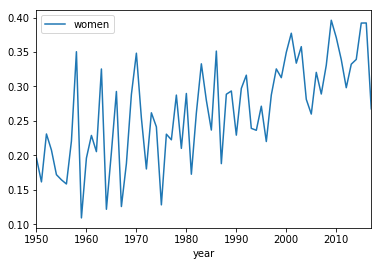

In [188]:
def percent_women_binned(cl_ls,group_val):
    df = pandas.DataFrame(cl_ls)
    grouped = df.groupby(group_val)
    target = []
    for group in grouped:
        new_row = {}
        classified = []
        index = group[0]
        g = grouped.get_group(index)
        for authors in g["genders"]:
            classified.append(class_gender(authors))
        new_row["women"] = percent_women(classified)
        new_row[group_val] = index
        target.append(new_row)
    return target

def class_gender(gender_ls):
    target = 'NA'
    for x in gender_ls:
        if x['gender'] == 'Female': ## THIS TREATS MIXED GENDER TEAMS AS FEMALE
            return 'Female'
    return 'Male'

def percent_women(class_ls):
    i = 0
    for x in class_ls:
        if x == "Female":
            i = i+1
    return float(i)/float(len(class_ls))
            
            
#for x in grouped:
#    index = x[0]
#    group = grouped.get_group(index)
#    print str(index) + str(num_titles(group))

tall_df = pandas.DataFrame(percent_women_binned(processed,"year")).set_index("year")
fig = tall_df.plot().get_figure()
fig.savefig("women_average_week.png")

#fig.savefig("women2")


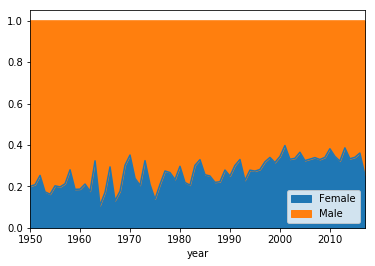

In [22]:
def unique_titles(df_ls):
    ta = set()
    ls = df_ls["title"]
    for x in ls:
        ta.add(x)
    return ta

def num_titles(ls):
    return len(unique_titles(ls))

def count_women_unweighted(ls,group_val):
    new_df = pandas.DataFrame(ls)
    new_df["genders"] = new_df["genders"].apply(class_gender)
    grouped =  new_df.groupby([group_val,"genders"]).apply(num_titles)
    temp = {}
    for index in grouped.index.values:
        year = index[0]
        if year in temp:
            row = temp[year]
        else:
            row = {}
        gender = index[1]
        row[gender] = grouped[index]
        temp[year] = row
    target = []
    for key in temp:
        new_row = {}
        new_row["year"] = key
        menn = temp[key]["Male"]
        womenn = temp[key]["Female"]
        new_row["Male"] = float(menn)/float(menn+womenn) # SCALING
        new_row["Female"] = float(womenn)/float(menn+womenn) # SCALING
        target.append(new_row)
    return target

df = pandas.DataFrame(count_women_unweighted(processed,"year")).set_index("year")
womens_fig = df.plot.area().get_figure()
womens_fig.savefig("womens_fig_scaled.png")

{'COME POUR THE WINE,  $12.95.) A': 'COME POUR THE WINE', 'THE CRADLE WILL FALL,  $10.95.) A': 'THE CRADLE WILL FALL', 'Norman Mailler': 'Norman Mailer', 'THE TENTH COMMANDMENT,  $11.95.) A': 'THE TENTH COMMANDMENT', 'THE SECOND COMING,  $12.95.) A': 'THE SECOND COMING'}
